<a href="https://colab.research.google.com/github/vrushali-broad/2018fall/blob/master/nn_hapmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
## Check if GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [22]:
## Mount Google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [23]:
%cd '/content/drive/My Drive/mutpip_paper/'
!ls

/content/drive/My Drive/mutpip_paper
 19_logs	       input.csv		  result_fm.pkl
 best_model_gp.keras  'July 2019 Notebook.gdoc'   result_gbrt.pkl
 hapmap.ids.txt        nn_hapmap.ipynb		  result_gp.pkl


In [0]:
## Import libraries
import pandas as pd
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

### Load Data

In [25]:
## input.csv is generated from *.ug.raw.vcf file in RVBoost (input for RVBoost.R)
## The label is 1 if the SNP is present in HAPMAP otherwise 0
df = pd.read_csv('input.csv',sep='\t', low_memory=False)
df.head()

,DJ,PctExtPos,ReadPosRankSum,QD,FS,ED,label
chr1:14522_G/A,161,0.00,0.400,0.82,0.0,8,0
chr1:14542_A/G,181,0.00,0.204,4.94,0.0,8,0
chr1:14574_A/G,213,0.25,2.339,4.11,0.0,8,0
chr1:14590_G/A,229,0.00,0.750,4.46,0.0,8,0
chr1:14599_T/A,230,0.00,1.083,8.39,0.0,8,0


In [26]:
# load the dataset
dataset = pd.read_csv('input.csv',sep='\t', low_memory=False)
from sklearn import preprocessing

x = dataset.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.head()


# split into input (X) and output (y) variables
X = dataset.loc[:,['DJ','PctExtPos','ReadPosRankSum','QD','FS','ED']]
y = dataset.loc[:,['label']]
#X = df.loc[:,0:5]
#y = df.loc[:,6]

## Check size of the training data and labels
X.shape, y.shape

((44107, 6), (44107, 1))

In [19]:
X.tail(2),y.tail(2)

(                     DJ  PctExtPos  ReadPosRankSum     QD     FS  ED
 chr9:140167022_G/A   45       0.04           1.810  12.74  8.470   1
 chr9:140167877_T/G  123       0.00           0.019  10.12  0.946   1,
                     label
 chr9:140167022_G/A      0
 chr9:140167877_T/G      1)

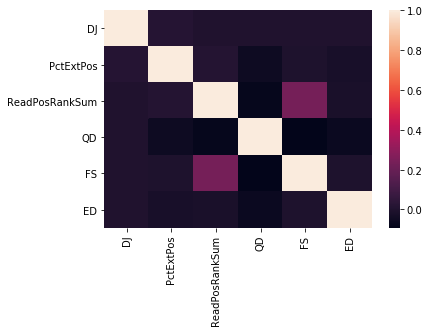

In [20]:
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [0]:
## Whitening the data - normalization
cols = list(X.columns)

train_mean = X[cols].mean(axis=0)
train_std = X[cols].std(axis=0)
X[cols] = (X[cols] - train_mean) / train_std
#validate[cols] = (validate[cols] - train_mean) / train_std
#test[cols] = (test[cols] - train_mean) / train_std

In [29]:
## Split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle= True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30874, 6), (13233, 6), (30874, 1), (13233, 1))

### Train Neural Net from DeepPVP

In [13]:
## Model from DeepPVP paper
from keras.regularizers import l1
import keras
reg = l1(0.001)
opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model = Sequential()
model.add(Dense(67, input_dim=6, activation='relu',activity_regularizer=l1(0.001)))
model.add(Dense(32, activation='relu',activity_regularizer=l1(0.001)))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

W0809 18:19:33.941071 139778003031936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 18:19:33.942867 139778003031936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 18:19:33.945451 139778003031936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 18:19:34.004472 139778003031936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 18:19:34.013256 139778003031936 deprecation_wrappe

In [34]:
## Run Model
model.fit(X, y, epochs=50, batch_size=1500)

Epoch 1/50
44107/44107 [==============================] - 3s 79us/step - loss: 11.0955 - acc: 0.7246
Epoch 2/50
44107/44107 [==============================] - 0s 4us/step - loss: 4.6437 - acc: 0.7246
Epoch 3/50
44107/44107 [==============================] - 0s 4us/step - loss: 1.8864 - acc: 0.7246
Epoch 4/50
44107/44107 [==============================] - 0s 3us/step - loss: 0.8778 - acc: 0.7246
Epoch 5/50
44107/44107 [==============================] - 0s 4us/step - loss: 0.6365 - acc: 0.7246
Epoch 6/50
44107/44107 [==============================] - 0s 4us/step - loss: 0.5950 - acc: 0.7246
Epoch 7/50
44107/44107 [==============================] - 0s 4us/step - loss: 0.5901 - acc: 0.7246
Epoch 8/50
44107/44107 [==============================] - 0s 4us/step - loss: 0.5893 - acc: 0.7246
Epoch 9/50
44107/44107 [==============================] - 0s 3us/step - loss: 0.5890 - acc: 0.7246
Epoch 10/50
44107/44107 [==============================] - 0s 4us/step - loss: 0.5888 - acc: 0.7246
Epoch 1

Since the accuracy stays constant at 72% even after 50 epochs, let's tune the model.
***
***

### Model Tuning

In [30]:
from keras.regularizers import l1
import keras
reg = l1(0.001)
opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model = Sequential()
model.add(Dense(64, input_dim=6, activation='relu',activity_regularizer=l1(0.001)))
model.add(Dense(128, activation='relu',activity_regularizer=l1(0.001)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

## Run Model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.33) #validation_data=(X_test, y_test))

Train on 20685 samples, validate on 10189 samples
Epoch 1/10
20685/20685 [==============================] - 4s 194us/step - loss: 0.5607 - acc: 0.7261 - val_loss: 0.5121 - val_acc: 0.7204
Epoch 2/10
20685/20685 [==============================] - 3s 148us/step - loss: 0.5107 - acc: 0.7267 - val_loss: 0.5072 - val_acc: 0.7204
Epoch 3/10
20685/20685 [==============================] - 3s 151us/step - loss: 0.5013 - acc: 0.7267 - val_loss: 0.5010 - val_acc: 0.7204
Epoch 4/10
20685/20685 [==============================] - 3s 160us/step - loss: 0.5010 - acc: 0.7267 - val_loss: 0.4971 - val_acc: 0.7204
Epoch 5/10
20685/20685 [==============================] - 3s 163us/step - loss: 0.4961 - acc: 0.7267 - val_loss: 0.5222 - val_acc: 0.7204
Epoch 6/10
20685/20685 [==============================] - 3s 157us/step - loss: 0.4970 - acc: 0.7267 - val_loss: 0.4903 - val_acc: 0.7204
Epoch 7/10
20685/20685 [==============================] - 3s 158us/step - loss: 0.4944 - acc: 0.7267 - val_loss: 0.4918 - 

In [43]:
import numpy as np
y_pred = model.predict_classes(X_test)

1 - np.sum(y_test-y_pred)/len(y_pred)
#ynew = model.predict(X_test)
#ynew[ynew>0.3]

array([0.39688984, 0.36464757, 0.3770936 , ..., 0.39688984, 0.39688984,
       0.39688984], dtype=float32)

In [0]:
(y_pred[y_pred>0.6])


array([0.72334087, 0.63284224, 0.60308313, 0.6625936 , 0.60655105,
       0.9171456 , 0.61723465, 0.6180813 , 0.6043245 , 0.97198725,
       0.7804998 , 0.6041637 , 0.61482203, 0.6706109 , 0.6072044 ,
       0.6044082 ], dtype=float32)

### Hyperparameter optimization

In [4]:
pip install scikit-optimize

     |████████████████████████████████| 81kB 1.5MB/s 


In [0]:
def create_model(learning_rate, num_dense_layers, num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    model = Sequential()
    model.add(Dense(64, input_dim=6, activation='relu',activity_regularizer=l1(0.001)))
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    model.add(Dense(1, activation='softmax'))
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [0]:
## Function to be optimized in skopt and hyperopt
@use_named_args(parameters)
def optimization(learning_rate, num_dense_layers,
            num_dense_nodes, activation):

    # Print the hyperparameters at each point
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Generate a model
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)
    
    model.summary()
    # Train the model
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_data=(X_test, y_test))

    # Classification accuracy on validation set
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print("Accuracy: {0:.2%}".format(accuracy))
    return -accuracy

In [0]:
## skopt
import skopt
from skopt import dump, load
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from keras.optimizers import Adam

start_parameters = [1e-5, 1, 16, 'relu']  ## Manual tuning
learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')
activation = Categorical(categories=['relu', 'sigmoid','tanh'],name='activation')

parameters = [learning_rate, num_dense_layers, num_dense_nodes, activation]


In [0]:
#!pip install keras==2.1
#import keras
#print(keras.__version__)

In [32]:
## GP
search_result = gp_minimize(func=optimization,
                            dimensions=parameters,
                            acq_func='EI',
                            n_calls=40, x0=start_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                448       
_________________________________________________________________
layer_dense_1 (Dense)        (None, 16)                1040      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________


W0809 18:23:49.505858 139778003031936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 30874 samples, validate on 13233 samples
Epoch 1/3
30874/30874 [==============================] - 4s 131us/step - loss: 12.5842 - acc: 0.2756 - val_loss: 12.5724 - val_acc: 0.2751
Epoch 2/3
30874/30874 [==============================] - 1s 33us/step - loss: 12.5616 - acc: 0.2756 - val_loss: 12.5500 - val_acc: 0.2751
Epoch 3/3
30874/30874 [==============================] - 1s 30us/step - loss: 12.5395 - acc: 0.2756 - val_loss: 12.5278 - val_acc: 0.2751
Accuracy: 27.51%
learning rate: 6.6e-03
num_dense_layers: 4
num_dense_nodes: 346
activation: tanh

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                448       
_________________________________________________________________
layer_dense_1 (Dense)        (None, 346)               22490     
_________________________________________________________________
layer_dense_2 (Dense)        (None, 346)

In [33]:
"Model parameters: ",search_result.x

          fun: -0.27514546966819386
    func_vals: array([-0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547,
       -0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547,
       -0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547,
       -0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547,
       -0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547,
       -0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547,
       -0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547,
       -0.27514547, -0.27514547, -0.27514547, -0.27514547, -0.27514547])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=1728990